In [1]:
import torch
import torch.nn.functional as F
import model, utils
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

In [2]:
device = utils.get_device()

CUDA Available:  True


In [3]:
## To get the std and mean value

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
pixel_means = cifar10_train.data.mean(axis=(0,1,2)) / 255.0
pixel_stds = cifar10_train.data.std(axis=(0,1,2)) / 255.0

print('CIFAR-10 pixel means:', pixel_means)
print('CIFAR-10 pixel stds:', pixel_stds)

Files already downloaded and verified
CIFAR-10 pixel means: [0.49139968 0.48215841 0.44653091]
CIFAR-10 pixel stds: [0.24703223 0.24348513 0.26158784]


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.4),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       #transforms.Resize((32, 32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.ToTensor(),
                                       transforms.Normalize(pixel_means, pixel_stds),
                                       #transforms.RandomHorizontalFlip(p = 0.5),
                                       #transforms.RandomCrop(28, padding=4),
                                       #transforms.RandomErasing(p=0.5, scale=(0.2, 0.4), ratio=(0.3, 3.3))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(pixel_means, pixel_stds)
                                       ])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

print(train.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


Files already downloaded and verified


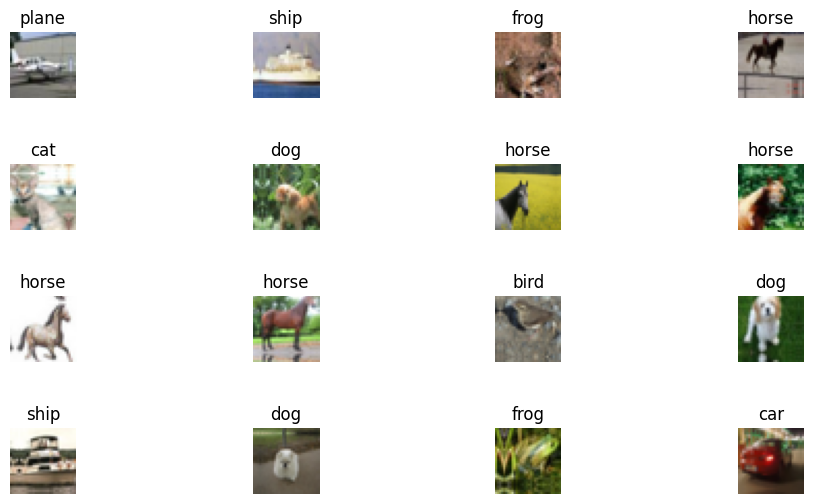

In [6]:
## Visulizing the data set

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a batch of images from the dataloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot the images using Matplotlib
fig, axs = plt.subplots(4, 4, figsize=(12, 6))
for i in range(16):
    # Calculate the subplot index
    row = i // 4
    col = i % 4
    # Unnormalize the image
    img = images[i] / 2 + 0.5
    # Convert the image to a NumPy array
    npimg = img.numpy()
    # Transpose the image from (C, H, W) to (H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))
    # Plot the image
    axs[row, col].imshow(npimg)
    axs[row, col].set_title(classes[labels[i]])
    axs[row, col].axis('off')

fig.subplots_adjust(hspace=1)
plt.show()

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cnnmodel = model.Net().to(device)
summary(cnnmodel, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             108
              ReLU-2            [-1, 4, 30, 30]               0
         LayerNorm-3            [-1, 4, 30, 30]           7,200
           Dropout-4            [-1, 4, 30, 30]               0
            Conv2d-5            [-1, 4, 28, 28]             144
              ReLU-6            [-1, 4, 28, 28]               0
         LayerNorm-7            [-1, 4, 28, 28]           6,272
           Dropout-8            [-1, 4, 28, 28]               0
            Conv2d-9            [-1, 4, 28, 28]              16
        MaxPool2d-10            [-1, 4, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             288
             ReLU-12            [-1, 8, 14, 14]               0

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(cnnmodel.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

EPOCHS = 20
criterion = F.nll_loss
misclassified = []
actual_labels = []
predicted_labels = []

In [10]:
for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  loss = model.train(cnnmodel, device, train_loader, criterion, optimizer, epoch)
  scheduler.step(loss)
  model.test(cnnmodel, device, test_loader)

Epoch 1


Loss=1.4446978569030762 Batch_id=1562 Accuracy=30.10: 100%|██████████| 1563/1563 [00:48<00:00, 32.00it/s]



Test set: Average loss: 1.6462, Accuracy: 4058/10000 (40.58%)

Epoch 2


Loss=1.6176055669784546 Batch_id=1562 Accuracy=38.01: 100%|██████████| 1563/1563 [00:43<00:00, 36.27it/s]



Test set: Average loss: 1.5401, Accuracy: 4377/10000 (43.77%)

Epoch 3


Loss=1.705967664718628 Batch_id=1562 Accuracy=41.07: 100%|██████████| 1563/1563 [00:43<00:00, 36.13it/s]



Test set: Average loss: 1.5096, Accuracy: 4514/10000 (45.14%)

Epoch 4


Loss=1.5850186347961426 Batch_id=1562 Accuracy=43.24: 100%|██████████| 1563/1563 [00:43<00:00, 36.01it/s]



Test set: Average loss: 1.4664, Accuracy: 4668/10000 (46.68%)

Epoch 5


Loss=1.3565093278884888 Batch_id=1562 Accuracy=44.39: 100%|██████████| 1563/1563 [00:43<00:00, 36.20it/s]



Test set: Average loss: 1.4521, Accuracy: 4764/10000 (47.64%)

Epoch 6


Loss=2.440849781036377 Batch_id=1562 Accuracy=45.46: 100%|██████████| 1563/1563 [00:43<00:00, 36.19it/s]



Test set: Average loss: 1.3815, Accuracy: 4920/10000 (49.20%)

Epoch 7


Loss=1.3649381399154663 Batch_id=1562 Accuracy=46.32: 100%|██████████| 1563/1563 [00:44<00:00, 35.38it/s]



Test set: Average loss: 1.3371, Accuracy: 5123/10000 (51.23%)

Epoch 8


Loss=1.282912015914917 Batch_id=1562 Accuracy=47.30: 100%|██████████| 1563/1563 [00:44<00:00, 34.89it/s]



Test set: Average loss: 1.3365, Accuracy: 5158/10000 (51.58%)

Epoch 9


Loss=1.281555414199829 Batch_id=1562 Accuracy=48.08: 100%|██████████| 1563/1563 [00:45<00:00, 34.23it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 1.3337, Accuracy: 5123/10000 (51.23%)

Epoch 10


Loss=1.3330905437469482 Batch_id=1562 Accuracy=51.11: 100%|██████████| 1563/1563 [00:43<00:00, 36.34it/s]



Test set: Average loss: 1.2213, Accuracy: 5530/10000 (55.30%)

Epoch 11


Loss=1.1157827377319336 Batch_id=1562 Accuracy=52.15: 100%|██████████| 1563/1563 [00:44<00:00, 35.32it/s]



Test set: Average loss: 1.2005, Accuracy: 5594/10000 (55.94%)

Epoch 12


Loss=1.6580358743667603 Batch_id=1562 Accuracy=52.47: 100%|██████████| 1563/1563 [00:44<00:00, 34.89it/s]


Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 1.1911, Accuracy: 5632/10000 (56.32%)

Epoch 13


Loss=1.123298168182373 Batch_id=1562 Accuracy=52.88: 100%|██████████| 1563/1563 [00:43<00:00, 36.05it/s]



Test set: Average loss: 1.1860, Accuracy: 5663/10000 (56.63%)

Epoch 14


Loss=0.7705602049827576 Batch_id=1562 Accuracy=52.78: 100%|██████████| 1563/1563 [00:43<00:00, 36.32it/s]



Test set: Average loss: 1.1853, Accuracy: 5664/10000 (56.64%)

Epoch 15


Loss=1.218324899673462 Batch_id=1562 Accuracy=53.24: 100%|██████████| 1563/1563 [00:43<00:00, 36.25it/s]


Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 1.1831, Accuracy: 5679/10000 (56.79%)

Epoch 16


Loss=1.3598082065582275 Batch_id=1562 Accuracy=52.91: 100%|██████████| 1563/1563 [00:43<00:00, 36.23it/s]



Test set: Average loss: 1.1824, Accuracy: 5695/10000 (56.95%)

Epoch 17


Loss=1.0242505073547363 Batch_id=1562 Accuracy=53.10: 100%|██████████| 1563/1563 [00:43<00:00, 36.10it/s]



Test set: Average loss: 1.1824, Accuracy: 5694/10000 (56.94%)

Epoch 18


Loss=1.1751503944396973 Batch_id=1562 Accuracy=53.18: 100%|██████████| 1563/1563 [00:44<00:00, 35.20it/s]

Epoch 00018: reducing learning rate of group 0 to 1.0000e-06.



Test set: Average loss: 1.1821, Accuracy: 5703/10000 (57.03%)

Epoch 19


Loss=1.1527832746505737 Batch_id=1562 Accuracy=53.10: 100%|██████████| 1563/1563 [00:43<00:00, 36.24it/s]



Test set: Average loss: 1.1821, Accuracy: 5704/10000 (57.04%)

Epoch 20


Loss=1.658045768737793 Batch_id=1562 Accuracy=53.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.36it/s]



Test set: Average loss: 1.1821, Accuracy: 5704/10000 (57.04%)



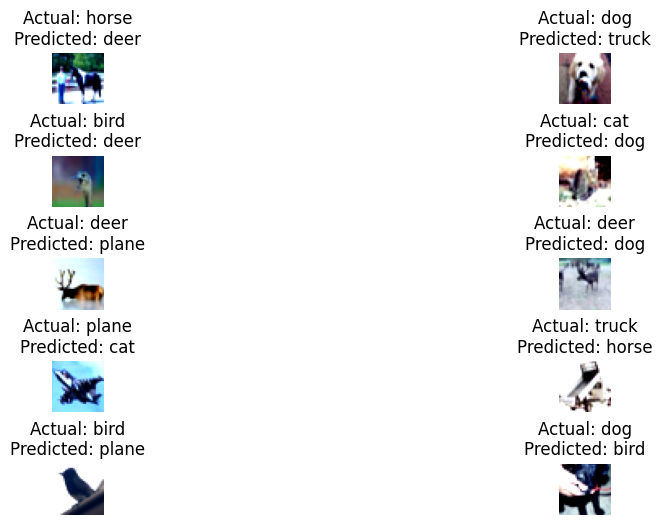

In [11]:
# To show the misclassified Images
model.plot_misclassifeid_images()

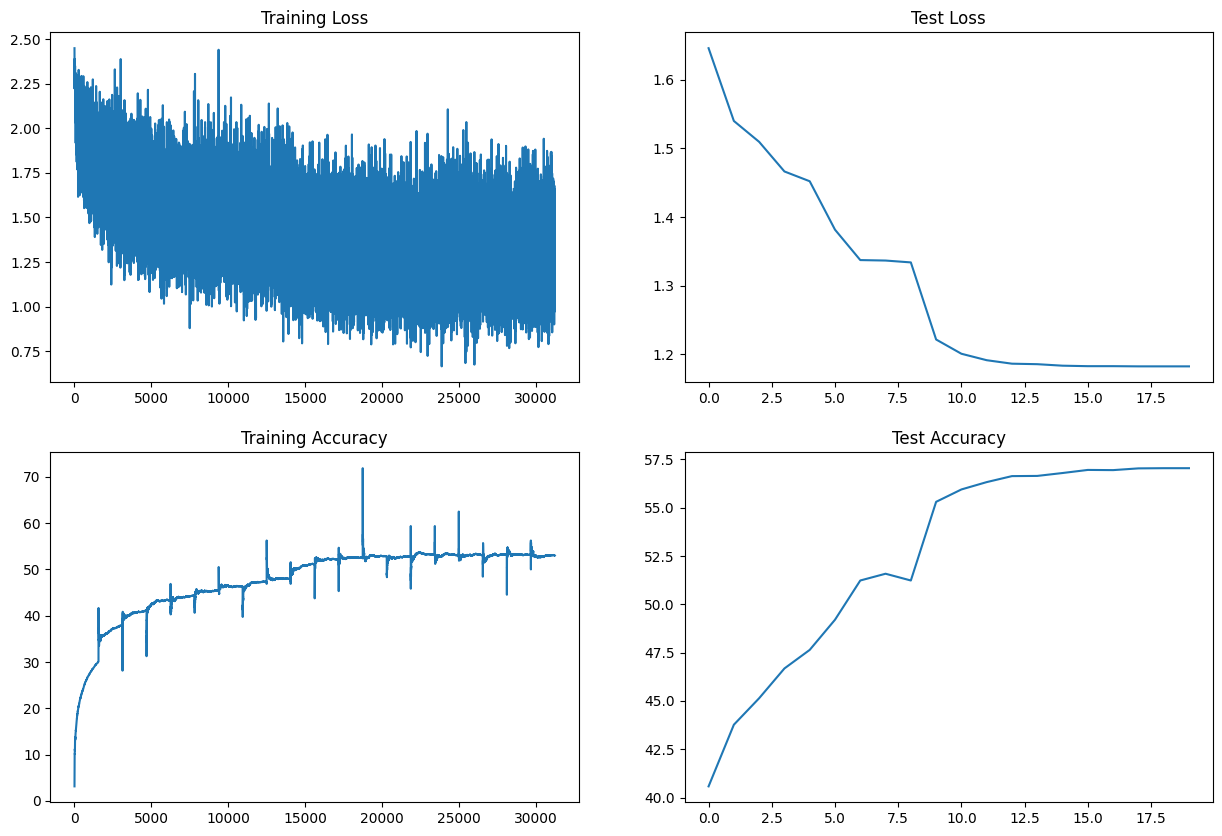

In [12]:
# Graph
model.plot_loss_accuracy_graph()